## Машинное обучение, ВМК МГУ

## Практическое задание 2

### Общая информация
Дата выдачи: 9 октября 2019

Максимальная оценка: 10 баллов + 1 бонусный балл

Мягкий дедлайн: 23:59MSK 23 октября (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 23:59MSK 30 октября.

### О задании

В этом задании вы:
- Познакомитесь с методом решения задачи регрессии на основе метода ближайших соседей.
- Реализуете алгоритм kNN для задачи регрессии.
- Изучите методы работы с категориальными и текстовыми переменными.


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-02-Username.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-02-ivanov.ipynb).

Далее отправьте этот файл на anytask в соответсвующий раздел.

In [1]:
import numpy as np
import pandas as pd

Все эксперименты в этой лабораторной работе предлагается проводить на данных соревнования New York City Airbnb Open Data: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data#AB_NYC_2019.csv

В данной задаче предлагается предсказать цену на съем квартиры в зависимости от её параметров.

In [2]:
data = pd.read_csv('AB_NYC_2019.csv')
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [3]:
data.shape

(48895, 16)

In [4]:
# число значений у признаков
for col_name in data.columns:
    print(col_name, len(data[col_name].unique()))

id 48895
name 47906
host_id 37457
host_name 11453
neighbourhood_group 5
neighbourhood 221
latitude 19048
longitude 14718
room_type 3
price 674
minimum_nights 109
number_of_reviews 394
last_review 1765
reviews_per_month 938
calculated_host_listings_count 47
availability_365 366


In [5]:
data.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Как видите, в данных есть пропуски. Не забудьте обработать их

In [6]:
# Ваш код здесь (ノ°∀°)ノ⌒･*:.｡. .｡.:*･゜ﾟ･*☆
numberCols = data.select_dtypes(include=[np.number]).columns.tolist()
numberCols.remove('id')
numberCols.remove('price')

categoricalCols = ['neighbourhood_group', 'neighbourhood', 'room_type']

data[numberCols] = data[numberCols].fillna(0)
data[categoricalCols] = data[categoricalCols].fillna('')

Разобъем данные на обучение и контроль.

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['price']), data[['price']],
                                                    test_size=0.3, random_state=241)

## Часть 1: Алгоритм kNN в задаче регрессии

<b> 1.1 (1.5 балла) </b>
Реализуйте класс `KNNRegressor`, который используя метод k ближайших соседей решает задачу регрессии. Для решение данной задачи, необходимо найти $N_k$ - k соседей, и после использовать значения их целевых переменных для предсказания:
\begin{align}
y = \frac{1}{k}\sum_{n \in N_k}w_n y_n,
\end{align}

где $w_n$ - вес каждого соседа. 

При этом `KNNRegressor` может работать в 2 режимах:
 - $uniform$ - ближайшие соседи учитываются с одинаковыми весами.
 - $distance$ - вес ближайших соседей зависит от расстояния
 
Сигнатуру методов при желании можно менять.

In [8]:
from typing import Union, Callable, Iterable, Optional
# from sklearn.neighbors import NearestNeighbors
# from sklearn.neighbors import KNeighborsRegressor

class KNNRegressor:
    def __init__(self, n_neighbors: int, metric: Union[str, Callable], mode: str = 'uniform'):
        """
        params:
            n_neighbors: number of neighbors
            metric: metric to use for distance computation
            mode: 'uniform' or 'distance'
            'uniform' - all points in each neighborhood are weighted equally
            'distance' - weight points by the inverse of their distance
        """
#         self.__nn = NearestNeighbors(n_neighbors = n_neighbors, metric = metric)
#         self.__nnTest = KNeighborsRegressor(n_neighbors = n_neighbors, metric = metric, weights = mode)
        self.__metric = metric
        self.__mode = mode
        self.__n_neighbors = n_neighbors

    def fit(self, X: np.array, y: np.array) -> None:
        """
            X: data
            y: labels
        """
        # Ваш код здесь
        self.__X = X
        self.__y = y
#         self.__nn.fit(X, y)
#         self.__nnTest.fit(X, y)
        
    def euclidean_distance(self, X, Y):
        d = len(X[0])
        res = np.zeros(len(X)*len(Y)).reshape(len(X), len(Y))
        for x in range(len(X)):
            for y in range(len(Y)):
                sum = 0
                for f in range(len(Y[y])):
                    sum += (X[x][f] - Y[y][f])**2
                res[x][y] = np.sqrt(sum)
        return res;

    def cosine_distance(self, X, Y):
        sumyy = (Y**2).sum(1)
        sumxx = (X**2).sum(1, keepdims=1)
        sumxy = X.dot(Y.T)
        return 1 - (sumxy / np.sqrt(sumxx)) / np.sqrt(sumyy)
    
    def overlap(self, X, Y):
        res = []
        res = np.zeros(len(X)*len(Y)).reshape(len(X), len(Y))
        for x in range(len(X)):
            for y in range(len(Y)):
                dist = 0
                for f in range(len(Y[y])):
                    if (X[x][f] != Y[y][f]):
                        dist = 1
                        break
                res[x][y] = dist
        return res;

    def flattened_overlap(self, X, Y):
        # находим частоту признаков
        freqs = {}
        for col in range(X.shape[1]):
            values, freq = np.unique(X[:,col], return_counts=True)
            freqs[col] = {values[q]: freq[q] for q in range(len(values))} 
        
        res = np.zeros(len(X)*len(Y)).reshape(len(X), len(Y))
        for x in range(len(X)):
            for y in range(len(Y)):
                dist = 0
                for с in range(len(Y[y])):
                    if (X[x][с] != Y[y][с]):
                        dist = dist + freqs[с][X[x][с]]
                
                res[x][y] = dist
        return res;
    
    def log_overlap(self, X, Y):
        
        # находим частоту признаков
        freqsX = {}
        for col in range(X.shape[1]):
            values, freq = np.unique(X[:,col], return_counts=True)
            freqsX[col] = {values[q]: freq[q] for q in range(len(values))} 

        freqsY = {}
        for col in range(Y.shape[1]):
            values, freq = np.unique(Y[:,col], return_counts=True)
            freqsY[col] = {values[q]: freq[q] for q in range(len(values))} 
        
        res = np.zeros(len(X)*len(Y)).reshape(len(X), len(Y))
        for x in range(len(X)):
            for y in range(len(Y)):
                dist = 0
                for f in range(len(Y[y])):
                    if (X[x][f] != Y[y][f]):
                        dist = dist + np.log(1 + freqsX[col][X[x][f]]) * np.log(1 + freqsY[col][Y[x][f]])
                
                res[x][y] = dist
        return res;

    def find_kneighbors(self, X, return_distance = True):
        
        if (self.__metric == 'euclidean'):
            dsModRes = self.euclidean_distance(X, self.__X)
        elif (self.__metric == 'cosine'):
            dsModRes = self.cosine_distance(X, self.__X)
        elif (self.__metric == 'overlap'):
            dsModRes = self.overlap(X, self.__X)
        elif (self.__metric == 'flattened_overlap'):
            dsModRes = self.flattened_overlap(X, self.__X)
        elif (self.__metric == 'log_overlap'):
            dsModRes = self.flattened_overlap(X, self.__X)
        else:
            raise Exception("Unknown 'metric' param value")

        res = []
        dists = []
        for i in range(len(dsModRes)):
            tmpDists = np.argsort(dsModRes[i])[:self.__n_neighbors]
            res.append(dsModRes[i][tmpDists])
            if (return_distance):
                dists.append(tmpDists)

        if (return_distance):
            return (res, dists)
        else:
            return (res)
        
    def predict(self, X: np.array, n_neighbors: Optional[int] = None) -> np.array:
        """
            X: data
            n_neighbors: number of neighbors
        """
        # Ваш код здесь
#         distances, indices = self.__nn.kneighbors(X)
#         distances, indices = self.__nnTest.kneighbors(X)
        distances, indices = self.find_kneighbors(X)
    
        if (self.__mode == 'uniform'):
            res = self.__y[indices].mean(axis=1)
        else: 
            res = []
            for row in range(len(indices)):
                predictedVal = 0
                weightsSum = 0
                for col in range(len(indices[row])):
                    w = 1 / (1 + distances[row][col])
                    weightsSum = weightsSum + w
                    predictedVal = predictedVal + w * self.__y[indices[row][col]]
                res.append(predictedVal / weightsSum)
            res = np.array(res)
#         return self.__nnTest.predict(X)
        return res
            

In [9]:
X_train1 = X_train[0:1000][numberCols].to_numpy()
X_test1 = X_test[0:1000][numberCols].to_numpy()
y_train1 = y_train[0:1000].to_numpy()[:,0]
y_test1 = y_test[0:1000].to_numpy()[:,0]

knnr = KNNRegressor(n_neighbors = 3, metric = 'euclidean', mode = 'uniform')
knnr.fit(X_train1, y_train1)
res = knnr.predict(X_test1)

print(res)

[ 86.66666667 333.33333333 260.         154.66666667 125.33333333
  70.         199.66666667 181.33333333 333.33333333  75.66666667
 241.66666667 140.          86.66666667  87.66666667 218.66666667
  88.66666667  90.33333333 130.         186.66666667 113.
 187.66666667 186.         195.          90.          86.66666667
 119.66666667  79.33333333  63.         130.         120.
 193.33333333 115.66666667  63.         111.         114.33333333
 183.33333333  56.33333333 129.33333333 183.33333333 212.33333333
 130.          68.33333333 176.66666667 319.66666667 104.66666667
 164.33333333 143.33333333  65.66666667 111.66666667  77.66666667
 270.         146.66666667 101.66666667 134.66666667 139.33333333
 129.          61.33333333  99.33333333 149.66666667  62.
  71.66666667  74.66666667  68.33333333  98.66666667  57.33333333
 113.33333333  85.66666667  98.         114.33333333 240.
 178.33333333  84.66666667 105.66666667  88.33333333 187.66666667
 110.66666667 111.33333333 175.          6

## Часть 2: Категориальные признаки

<b>2.1 (1 балл)</b>
Реализуйте три функции расстояния на категориальных признаках, которые обсуждались на [третьем семинаре](https://github.com/mmp-mmro-team/mmp_mmro_fall_2019/blob/master/lecture-notes/Sem03_knn.pdf). Не забудьте, что KNNRegressor должен уметь работать с этими функциями расстояния. Как вариант, можно реализовать метрики как [user-defined distance](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html).

In [11]:
X_train1 = X_train[0:1000][categoricalCols].to_numpy()
X_test1 = X_test[0:1000][categoricalCols].to_numpy()
y_train1 = y_train[0:1000].to_numpy()[:,0]
y_test1 = y_test[0:1000].to_numpy()[:,0]

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

X_train1[:, 0] = labelencoder.fit_transform(X_train1[:, 0])
X_train1[:, 1] = labelencoder.fit_transform(X_train1[:, 1])
X_train1[:, 2] = labelencoder.fit_transform(X_train1[:, 2])

X_test1[:, 0] = labelencoder.fit_transform(X_test1[:, 0])
X_test1[:, 1] = labelencoder.fit_transform(X_test1[:, 1])
X_test1[:, 2] = labelencoder.fit_transform(X_test1[:, 2])

<b>2.2 (1 балл)</b> Найдите все категориальные признаки в данных. Подсчитайте для каждой из метрик качество на тестовой выборке `X_test` при числе соседей $k = 10$. Качество измеряйте с помощью RMSE.

Какая функция расстояния оказалась лучшей? Почему?

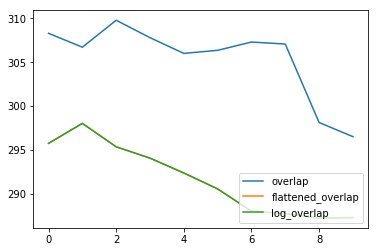

In [46]:
# Ваш код здесь
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

k_max = 10
metrics_array = ['overlap', 'flattened_overlap', 'log_overlap']
res = np.zeros(k_max * len(metrics_array)).reshape(k_max, len(metrics_array))
for m in range(len(metrics_array)):
    for k in range(k_max):
        knnr = KNNRegressor(n_neighbors = k + 1, metric = metrics_array[m], mode = 'uniform')
        knnr.fit(X_train1, y_train1)
        pred = knnr.predict(X_test1)
        res[k][m] = np.sqrt(mean_squared_error(y_test1, pred))

plt.plot(res)
plt.legend(metrics_array, loc='lower right')
plt.show() 

<b>2.3 (1 балл) бонус</b> Подберите лучшее (на тестовой выборке) число соседей $k$ для каждой из функций расстояния. Какого удалось достичь уровня качества?

In [ ]:
# Ваш код здесь

<b>2.4 (2.5 балла)</b> Отойдем ненадолго от задачи регрессии и перейдём к задаче классификации: будем определять, являеться ли квартира дорогой $(target = 1)$ или дешевой $(target = 0)$. Будем считать дорогими квариры, цена которых выше среднего.

In [ ]:
data['target'] = (data.price > data.price.mean()).astype(int)

Реализуйте счетчики, которые заменят категориальные признаки на вещественные.

А именно, для каждого категориального признака $f_j(x)$ необходимо сделать следующее:
1. Число `counts` объектов в обучающей выборке с таким же значением признака.
\begin{align}
counts_j(c) = \sum_{i=1}^l [f_j(x_i) = c]
\end{align}
2. Число `successes` объектов первого класса ($y = 1$) в обучающей выборке с таким же значением признака.
\begin{align}
successes_j(c) = \sum_{i=1}^l[f_j(x_i) = c][y_i = +1].
\end{align}
3. Сглаженное отношение двух предыдущих величин:
\begin{align}
p_j(c) = \frac{successes_j(c) + a}{counts_j(c) + b},
\end{align}

где $a$ и $b$ - априорные счетчики (например, a = 1, b = 2).

In [ ]:
def counters(x):
    """
    params:
        x: value on categorical feature for N objects
    returns: vector of length N
    """
    # Ваш код здесь
    pass

Поскольку признаки, содержащие информацию о целевой переменной, могут привести к переобучению, может оказаться полезным сделать *фолдинг*: разбить обучающую выборку на $n$ частей, и для $i$-й части считать `counts` и `successes` по всем остальным частям. Для тестовой выборки используются счетчики, посчитанный по всей обучающей выборке. Реализуйте и такой вариант. Достаточно взять $n = 3$.

In [ ]:
def fold_counters(x):
    """
    params:
        x: value on categorical feature for N objects
    returns: vector of length N
    """
    # Ваш код здесь
    pass

Посчитайте на тесте AUC-ROC метода $k$ ближайших соседей с евклидовой метрикой для выборки, где категориальные признаки заменены на счетчики. Сравните по AUC-ROC два варианта формирования выборки — с фолдингом и без. Не забудьте подобрать наилучшее число соседей $k$.

In [ ]:
# Ваш код здесь

<b>2.5 (1 балл)</b> Вернемся к задаче регрессии. Утверждается, что для задачи регрессии можно также сделать преобразование категориальных признаков в действительные числа. Для этого достаточно для каждого значения признака $f_j$ вычислить:
\begin{align}
p_j(c) = g(T_i | f_j(x_i) = c),
\end{align}

где $T_i$ - значения целевой переменной объекта $x_i$. Функция $g$ - среднее (mean) или среднеквадратичное отклонение (std).

Закодируйте категориальные признаки обоими способами и найдите значение RMSE. Используйте евклидову метрику для поиска ближайших соседей. Для какой функции $g$ значение RMSE лучше? Почему?

In [ ]:
# Ваш код здесь

## Часть 3: Текстовые признаки

<b>3.1 (2 балла)</b> Перейдем от категориальным признаков к текстовым. Рассмотрим 2 способа преобразования текста в действительные числа:
- Мешок слов (Bag of Words)
- TF-IDF

[Здесь](https://scikit-learn.org/stable/modules/feature_extraction.html) вы можете прочитать про их применение в Питоне.

Сравните оба способа на задаче регресси. Какую лучше метрику использовать: евклидову или косинусную меру? Постройте графики зависимости качества решения задачи от способа преобразования, метрики и количества соседей. Мера качества - RMSE.

Объясните полученные результаты.

Перед преобразованием не забудьте уменьшить размер словаря. Например, это можно сделать за счет приведения всех слов к одному регистру и удаления [стопслов](https://en.wikipedia.org/wiki/Stop_words) (артиклей, предлогов, союзов).

In [ ]:
# Ваш код здесь

<b>3.2 (1 балл)</b> Используя все доступные признаки, решите задачу регрессии. Для категориальных и текстовых признаков выберите лучшие преобразования. Повлияло ли добавление количественного признака на метрику качества?

In [7]:
# Ваш код здесь

## Часть 4: Выводы


In [6]:
# Ваши выводы здесь (ノ°∀°)ノ⌒･*:.｡. .｡.:*･゜ﾟ･*☆